# MNIST Image Classification - SkFlow, TensorFlow

In [2]:
import pandas as pd
import numpy as np
from sklearn import datasets, cross_validation, metrics
import tensorflow as tf
import skflow
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import seaborn as sns
%matplotlib inline  

In [3]:
# Function to display single image
def view_image(image, label="", predicted=""):
    if predicted != "":
        print("Predicted: %s" % label , "Actual: %s" % predicted)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.show()

## Load Data using TensorFlow

In [5]:
mnist = input_data.read_data_sets('MNIST_data')
print ("Image Dimensions", mnist.test.images.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
('Image Dimensions', (10000, 784))


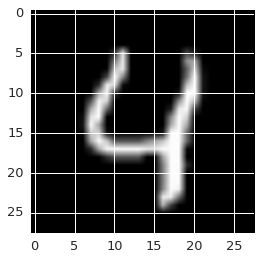

In [39]:
#sample an image
view_image(np.reshape(mnist.test.images[0], [28, 28]))

## Classifiers

### Model 1

In [6]:
# TensorFlow model using Scikit Flow ops
def conv_model(X, y):
    X = tf.expand_dims(X, 3)
    features = tf.reduce_max(skflow.ops.conv2d(X, 12, [3, 3]), [1, 2])
    features = tf.reshape(features, [-1, 12])
    return skflow.models.logistic_regression(features, y)

classifier = skflow.TensorFlowEstimator(model_fn=conv_model, n_classes=10,
                                        steps=1000, learning_rate=0.05,
                                        batch_size=128)

In [7]:
classifier = skflow.TensorFlowLinearClassifier(
    n_classes=10, batch_size=100, steps=1000, learning_rate=0.01)
classifier.fit(mnist.train.images, mnist.train.labels)
score = metrics.accuracy_score(mnist.test.labels, classifier.predict(mnist.test.images))
print('Accuracy: {0:f}'.format(score))

Step #1, avg. loss: 2.64234
Step #101, avg. loss: 1.90145
Step #201, avg. loss: 1.36286
Step #301, avg. loss: 1.10363
Step #401, avg. loss: 0.95203
Step #501, avg. loss: 0.85592
Step #601, epoch #1, avg. loss: 0.78724
Step #701, epoch #1, avg. loss: 0.73279
Step #801, epoch #1, avg. loss: 0.70121
Step #901, epoch #1, avg. loss: 0.65916
Accuracy: 0.860700


### Model 2

In [116]:
def max_pool_2x2(tensor_in):
    return tf.nn.max_pool(tensor_in, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
        padding='SAME')

def conv_model(X, y):
    # reshape X to 4d tensor with 2nd and 3rd dimensions being image width and height
    # final dimension being the number of color channels
    X = tf.reshape(X, [-1, 28, 28, 1])
    # first conv layer will compute 32 features for each 5x5 patch
    with tf.variable_scope('conv_layer1'):
        h_conv1 = skflow.ops.conv2d(X, n_filters=10, filter_shape=[5, 5], 
                                    bias=True, activation=tf.nn.relu)
        h_pool1 = max_pool_2x2(h_conv1)
    # second conv layer will compute 64 features for each 5x5 patch
    with tf.variable_scope('conv_layer2'):
        h_conv2 = skflow.ops.conv2d(h_pool1, n_filters=64, filter_shape=[5, 5], 
                                    bias=True, activation=tf.nn.relu)
        h_pool2 = max_pool_2x2(h_conv2)
        # reshape tensor into a batch of vectors
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
    # densely connected layer with 1024 neurons
    h_fc1 = skflow.ops.dnn(h_pool2_flat, [500], activation=tf.nn.relu, keep_prob=0.5)
    return skflow.models.logistic_regression(h_fc1, y)

In [117]:
# Create a classifier, train and predict.
classifier = skflow.TensorFlowEstimator(
    model_fn=conv_model, n_classes=10, batch_size=100, steps=2000,
    learning_rate=0.001)

classifier.fit(mnist.train.images, mnist.train.labels)


Step #1, avg. loss: 3.06144
Step #201, avg. loss: 2.38898
Step #401, avg. loss: 2.15633
Step #601, epoch #1, avg. loss: 1.99778
Step #801, epoch #1, avg. loss: 1.81714
Step #1001, epoch #1, avg. loss: 1.59843
Step #1201, epoch #2, avg. loss: 1.39710
Step #1401, epoch #2, avg. loss: 1.19029
Step #1601, epoch #2, avg. loss: 1.04447
Step #1801, epoch #3, avg. loss: 0.93614


TensorFlowEstimator(batch_size=100, class_weight=None,
          continue_training=False, early_stopping_rounds=None,
          keep_checkpoint_every_n_hours=10000, learning_rate=0.001,
          max_to_keep=5, model_fn=<function conv_model at 0x7f772f86eed8>,
          n_classes=10, num_cores=4, optimizer='SGD', steps=2000,
          tf_master='', tf_random_seed=42, verbose=1)

In [8]:
score = metrics.accuracy_score(mnist.test.labels, classifier.predict(mnist.test.images))
print('Test Accuracy: {0:f}'.format(score))
predicted = classifier.predict(mnist.test.images)

Test Accuracy: 0.860700


In [10]:
confusion_matrices = {}
confusion_matrices["name"] =  pd.crosstab(index=mnist.test.labels, columns= predicted.ravel(), rownames=['True'], colnames=['Predicted'])

In [11]:
classifiers ={"Model1" : classifier}

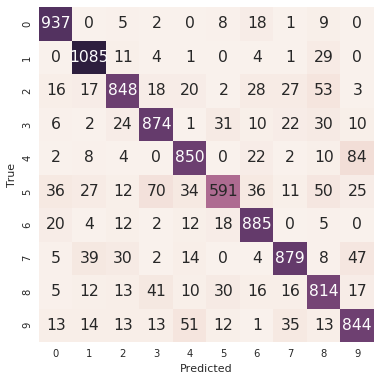

In [13]:
# Plot Confusion Matrices
# print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predicted))
fix, ax = plt.subplots(figsize=(6, 6))
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})
for name, matrix in confusion_matrices.items():
    sns.heatmap(matrix, annot=True, square=False, fmt='', cbar=False)

('Predicted: 7', 'Actual: 7')


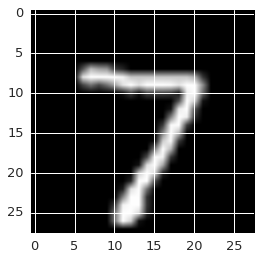

('Predicted: 2', 'Actual: 2')


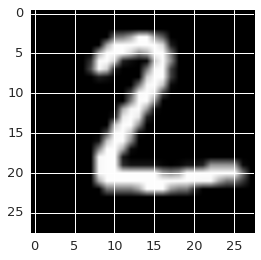

('Predicted: 1', 'Actual: 1')


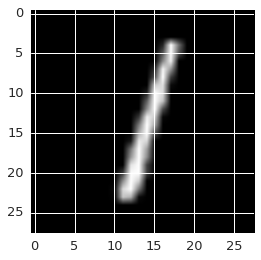

('Predicted: 0', 'Actual: 0')


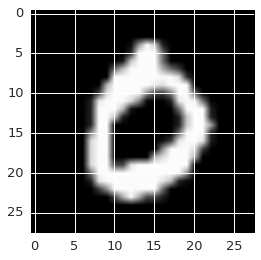

('Predicted: 4', 'Actual: 4')


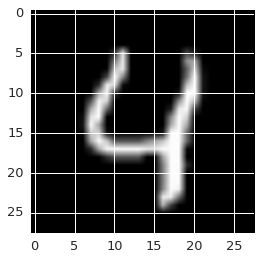

In [38]:
for i in range(0, 5):
    image = np.reshape(mnist.test.images[i], [28, 28])
    view_image(image, mnist.test.labels[i], predicted[i])